# Graph embeddings

In [1]:
import sys
sys.path.append('../src')
from graph_utils import get_all_user_graphs, get_all_twitter_user_graphs
from fsm import gspan_to_igraph

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import networkx as nx
import igraph as ig

import json

from karateclub import (FGSD, GL2Vec, FeatherGraph, Graph2Vec, LDP, SF)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

/home/mahf/Desktop/thesis/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data

In [2]:
graphs_ig = get_all_user_graphs() + get_all_twitter_user_graphs()
lccs_ig = [g.components(mode='weak').giant() for g in graphs_ig]
names = [g['name'] for g in graphs_ig]

# convert to nx graphs
graphs = [g.simplify().to_networkx() for g in graphs_ig]
lccs = [g.simplify().to_networkx() for g in lccs_ig]

#### Create random reference graphs

In [3]:
er = [ig.Graph.Erdos_Renyi(n=g.number_of_nodes(), m=g.number_of_edges()).to_networkx() for g in graphs for _ in range(1)]

conf = [
        ig.Graph.Degree_Sequence(
            graph.degree(loops=False, mode='out'),
            graph.degree(loops=False, mode='in')
        ).simplify().to_networkx()
        for graph in lccs_ig for _ in range(1)]

graphs_random = graphs + er + conf
markers = ['o' for _ in range(len(graphs))] +\
            ['s' for _ in range(len(er))] +\
            ['^' for _ in range(len(conf))]
colors = ['blue' for _ in range(len(graphs))] +\
            ['red' for _ in range(len(er))] +\
            ['green' for _ in range(len(conf))]

#### Assign categories

In [4]:
category_dict = {
    'anime': 'Shared interest/subculture',
    'booktok': 'Shared interest/subculture',
    'football': 'Shared interest/subculture',
    'gym': 'Shared interest/subculture',
    'jazz': 'Shared interest/subculture',
    'kpop': 'Shared interest/subculture',
    'lgbt': 'Shared interest/subculture',
    'makeup': 'Shared interest/subculture',
    'minecraft': 'Shared interest/subculture',
    'plantsoftiktok': 'Shared interest/subculture',
    'biden2024': 'Political discussion',
    'blacklivesmatter': 'Political discussion',
    'climatechange': 'Political discussion',
    'conspiracy': 'Political discussion',
    'election': 'Political discussion',
    'gaza': 'Political discussion',
    'israel': 'Political discussion',
    'maga': 'Political discussion',
    'palestine': 'Political discussion',
    'trump2024': 'Political discussion',
    'asmr': 'Entertainment/knowledge',
    'challenge': 'Entertainment/knowledge',
    'comedy': 'Entertainment/knowledge',
    'learnontiktok': 'Entertainment/knowledge',
    'movie': 'Entertainment/knowledge',
    'news': 'Entertainment/knowledge',
    'science': 'Entertainment/knowledge',
    'storytime': 'Entertainment/knowledge',
    'tiktoknews': 'Entertainment/knowledge',
    'watermelon': 'Entertainment/knowledge'
}
categories = np.array([category_dict.get(name, 'other') for name in names])
cmap = {'Shared interest/subculture': 'r', 'Political discussion': 'g', 'Entertainment/knowledge': 'b', 'other': 'k'}

## Embeddings
#### FeatherGraph embeddings

[0.40019406 0.2667826 ]


/home/mahf/Desktop/thesis/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


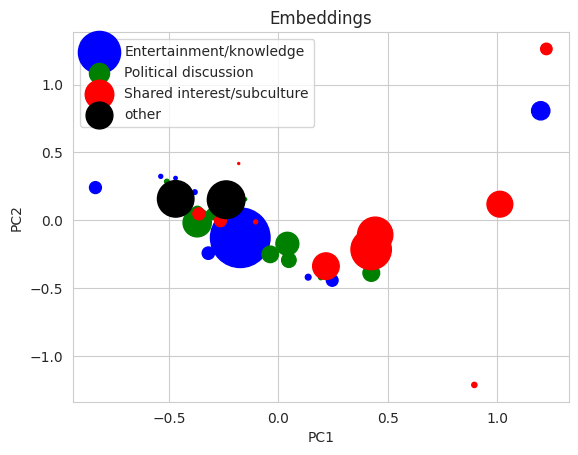

In [5]:
# define, fit and transform model
model = FeatherGraph()
model.fit(lccs)
X = model.get_embedding()

# dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X)

x = X_pca

fig, ax = plt.subplots()
sizes = np.array([g.vcount() for g in lccs_ig])
for cat in np.unique(categories):
    ax.scatter(*x[categories==cat].T, label=cat, color=cmap[cat], s=sizes[categories==cat])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Embeddings')

# for i, txt in enumerate(names):
#     ax.annotate(txt, x[i])
ax.legend()

### Graph2Vec embeddings

[0.82426137 0.1176287 ]


/home/mahf/Desktop/thesis/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


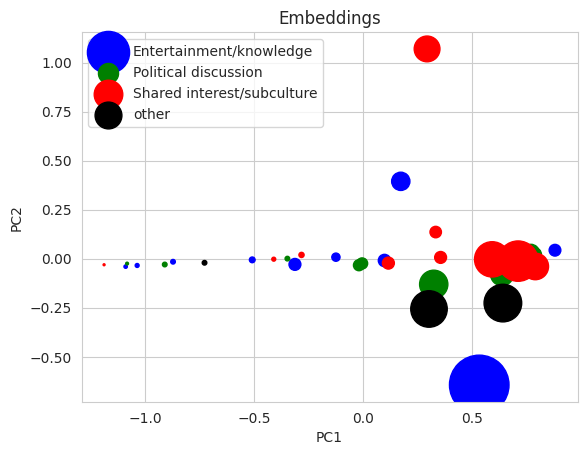

In [6]:
# define, fit and transform model
model = Graph2Vec()
model.fit(lccs)
X = model.get_embedding()

# dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X)

x = X_pca

fig, ax = plt.subplots()
sizes = np.array([g.vcount() for g in lccs_ig])
for cat in np.unique(categories):
    ax.scatter(*x[categories==cat].T, label=cat, color=cmap[cat], s=sizes[categories==cat])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Embeddings')

#for i, txt in enumerate(names):
#    ax.annotate(txt, x[i])
ax.legend()

#### Using motifs as embeddings

[0.86462094 0.04517423]


/home/mahf/Desktop/thesis/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


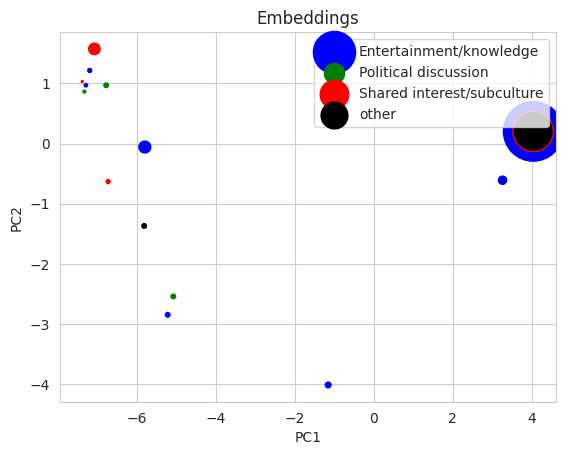

In [7]:
# load motifs
motif_data = json.load(open('../data/fsm/subgraph_data/lcc.json'))

# extract motif matrix
motif_matrix = [motif['graph_occurrences'] + motif['twitter_occurences'] for motif in motif_data]
X = np.array(motif_matrix, dtype=np.int32).T

# dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X)

x = X_pca

fig, ax = plt.subplots()
sizes = np.array([g.vcount() for g in lccs_ig])
for cat in np.unique(categories):
    ax.scatter(*x[categories==cat].T, label=cat, color=cmap[cat], s=sizes[categories==cat])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Embeddings')

# for i, txt in enumerate(names):
#     ax.annotate(txt, x[i])
ax.legend()

### Significant motif embeddings

[0.76630671 0.135939  ]


/home/mahf/Desktop/thesis/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


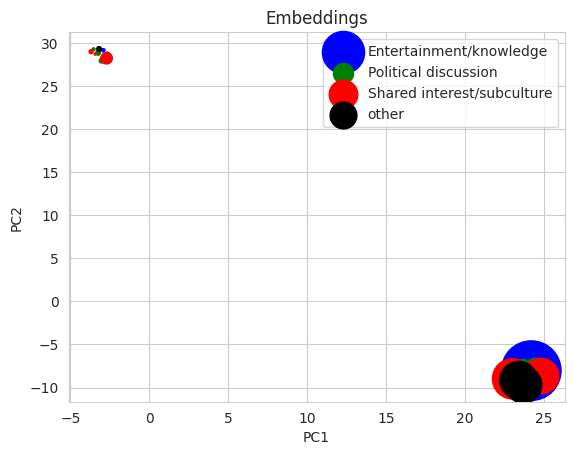

In [8]:
mask = [data['graph_support'] / data['er_support'] >= 1.2 for data in motif_data]
X_significant = X[:, mask]

# dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_significant)
print(pca.explained_variance_ratio_)

umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X_significant)

x = X_umap

fig, ax = plt.subplots()
sizes = np.array([g.vcount() for g in lccs_ig])
for cat in np.unique(categories):
    ax.scatter(*x[categories==cat].T, label=cat, color=cmap[cat], s=sizes[categories==cat])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Embeddings')

# for i, txt in enumerate(names):
#     ax.annotate(txt, x[i])
ax.legend()